# Calculating Thermal Time from Land Surface Temperature. 

This Jupyter Notebook demonstrates how to calculate Thermal Time or Growing Degree Days based on the Land Surface Temperature product using the Processing API.

In this example, cumulative thermal time is calcualted for a single field. 

In [1]:
import json
import numpy as np
import folium

import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import sentinelhub
from sentinelhub import (
    SHConfig,
    Geometry,
    CRS,
    SentinelHubStatistical,
    DataCollection,
    SentinelHubDownloadClient,
)



## Credentials
To obtain your `client_id` & `client_secret`, you need to navigate to your [Dashboard](https://apps.sentinel-hub.com/dashboard/#/). In the User Settings, you can create a new OAuth client to generate these credentials. More detailed instructions can be found on the corresponding documentation page.

Now that you have your `client_id` & `client_secret`, it is recommended to configure a new profile in your Sentinel Hub Python package. Instructions on how to configure your Sentinel Hub Python package can be found [here](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). This is useful as changes to the config class in your notebook are usually only temporary and by saving the configuration to your profile, you don't have to generate new credentials or overwrite/change the default profile every time you run or write a new Jupyter Notebook.

In [2]:
config = SHConfig()

if not config.sh_client_id or not config.sh_client_secret:
    print("No credentials found, please provide the OAuth client ID and secret.")
else:
    print("Connected to Sentinel Hub")

Connected to Sentinel Hub


### Define Field of Interest 

In this example a field of interest has been selected in Des Moines, Iowa USA. The field boundary is defined as a GeoJSON file in EPSG:4326. We will read the geoJSON and plot the area of interest.

In [22]:
# Read a geojson containing a polygon representing the city of Bordeaux, France
with open("./../example_data/des_moines_FOI.geojson") as file:
    foi_json = json.load(file)

# Load GeoJSON into a shapely polygon
foi_polygon = Polygon(foi_json["features"][0]["geometry"]["coordinates"][0])

# Convert shapely polygon to a Sentinel Hub geometry
foi = Geometry(foi_polygon, crs=CRS(4326))

In [23]:
# Plot the field on an interactive map
m = folium.Map(
    location=[
        foi_polygon.centroid.coords.xy[1][0],
        foi_polygon.centroid.coords.xy[0][0],
    ],
    zoom_start=15,
    tiles="OpenStreetMap",
)
geo_j = folium.GeoJson(data=foi_polygon, style_function=lambda x: {"fillColor": "blue"})
geo_j.add_to(m)
m

## Set link to the Planet Sandbox Collection

Land Surface Temperature is available through the Subscriptions API. Once the area of interest and variables are subscribed to, the data can be automatically delivered into a Sentinel Hub collection if you use the Sentinel Hub delivery option.

In this example, we will use the Land Surface Temperature collection available from Planet Sandbox Data.

For more information on how to call a collection ID in a request with Python, you can refer to the sentinelhub-py documentation.

In [81]:
collection_id= "8d977093-cf9e-4351-8159-90f2522c29c1"
data_collection = DataCollection.define_byoc(collection_id)

## Calculating Thermal Time

A time series for the field average daily minimum and and maximum temperature will be constructed using LST, linear regression and the Sentinel Hub Statistics API. The thermal time calulation will then be performed with a base development value of 10 degrees celcius, this value can be changed and should be set based on the crop in the field of interest. A cumulative calculation will be performed from the start date to the end date. 

We will perform the thermal time calculation with the following parameters:

- The Sandbox Data collection Land Surface Temperature `(data_collection)`
- Cumulative calculation from May 1st, 2018 to October 31st, 2018
- At the native resolution (0.01 degree -> ±1km)
- Using our previously defined function `(calculate_thermal_time)`
- Calculated for each day `(P1D)`
- Over the geometry our field of interest `(foi)`
- Crop base development threshold of 10 degrees celcius. 



In [27]:
def get_time_series(temp_extreme : str, 
                    time_of_interest : tuple, 
                    input_data : sentinelhub.api.base_request.InputDataDict,
                    parcel_geo : sentinelhub.geometry.Geometry,
                    config : sentinelhub.config.SHConfig) -> pd.Series:
    
    """Get time series of LST data from sentinel hub statstics API and addjust to daily temperature extreme"""

    # set parameters for max or min temperature calculation 
    if temp_extreme == 'max': 
        sensing_time = '"1330"'
        coefficient = 0.57263731
        intercept = 5.93745546

    if temp_extreme == 'min': 
        sensing_time= '"0130"'
        coefficient = 0.3175429
        intercept = 2.15137094

    # eval script for getting time series and adjusting to daily temperature extreme
    time_series_evalscript = f"""
    //VERSION=3

    function setup() {{
        return {{
            input: [{{bands: ["LST", "dataMask"]}}],
            output: [
                {{ id: "LST", bands: 1, sampleType: "FLOAT32" }},
                {{ id: "dataMask", bands: 1, sampleType: "UINT8" }}
            ],
            mosaicking: "TILE"
        }};
    }}

    // linear regression function
    function applyLinearRegression(x) {{
        return ({coefficient} * x) + {intercept}
    }}


    // Filter out scenes where the sensing time matches specified sensing time
    function preProcessScenes (collections) {{
        collections.scenes.tiles = collections.scenes.tiles.filter(function (tile) {{
            return tile.dataPath.includes("T"+{sensing_time});
        }})
        collections.scenes.tiles.sort((a, b) => new Date(b.date) - new Date(a.date));
        return collections
    }}

    // Convert Land Surface Temperature to celcius and apply linear regression
    function evaluatePixel(samples) {{

        var sample = samples[0].LST
        var nodata = samples[0].dataMask

        //convert to celcius 
        var celcius = (sample / 100) - 273.5

        //linear regression
        var air_temp = applyLinearRegression(celcius)


        return {{
            LST: [celcius],
            dataMask: [nodata]
        }};
    }}
    """
    
    # Set up Sentinel Hub request
    request = SentinelHubStatistical(
        aggregation=SentinelHubStatistical.aggregation(evalscript=time_series_evalscript, 
                                                       time_interval=time_of_interest, 
                                                       aggregation_interval="P1D", 
                                                       resolution=(0.01, 0.01)),# SHOULD THIS BE HARDCODED? 
                                                       input_data=[input_data],
                                                       geometry=parcel_geo,
                                                       config=config,
                                                        )

    # Make request and download response
    download_requests = [request.download_list[0]]
    client = SentinelHubDownloadClient(config=config)
    response = client.download(download_requests)

    # Format response into Pandas dataframe
    series = pd.json_normalize(response[0]["data"])
    series['date'] = pd.to_datetime(series['interval.from'])
    series['date'] = series['date'].dt.date
    series.set_index('date', inplace=True)

    series = series[['outputs.LST.bands.B0.stats.mean']].rename({'outputs.LST.bands.B0.stats.mean':temp_extreme}, axis= 1)
    series[temp_extreme] = pd.to_numeric(series[temp_extreme], errors = 'coerce')

    return series

def calculate_thermal_time(time_of_interest : tuple, 
                           input_data : sentinelhub.api.base_request.InputDataDict, 
                           parcel_geo : sentinelhub.geometry.Geometry, 
                           config : sentinelhub.config.SHConfig,
                           base_value : int, 
                           upper_value : int = 0) -> pd.Series:

    # get max and min temp from Sentinel Hub Statistics API 
    max_temp = get_time_series('max', time_of_interest, input_data, parcel_geo, config)
    min_temp = get_time_series('min', time_of_interest, input_data, parcel_geo, config)
    temp_extremes =  max_temp.join(min_temp, how='outer')

    # interpolate any missing days 
    temp_extremes = temp_extremes.interpolate()

    # calcualate daily thermal time 
    temp_extremes[temp_extremes < base_value] = base_value
    if upper_value != 0:
        temp_extremes[temp_extremes > upper_value] = upper_value
    
    # Apply thermal time equation
    temp_extremes['GDD'] = (temp_extremes['max'] + temp_extremes['min']) / 2 - base_value
    temp_extremes[temp_extremes < 0] = 0 # handle any cases where daily min was greater than max 

    return temp_extremes['GDD'].cumsum()



In [30]:
# LST input data
input_data = SentinelHubStatistical.input_data(data_collection)

# start and end date 
time_of_interest = '2018-04-01', '2018-10-31'

# crop specific base value over which growth occurs
base_value = 10

thermal_time = calculate_thermal_time(time_of_interest = time_of_interest, 
                                      input_data = input_data, 
                                      parcel_geo = foi, 
                                      config = config, 
                                      base_value=base_value)

In [31]:
thermal_time.head()

date
2018-04-01    0.000000
2018-04-02    0.000000
2018-04-03    0.452500
2018-04-04    2.562500
2018-04-05    7.282501
Name: GDD, dtype: float64

## Plot the result 

Plot cumulative thermal time against date.

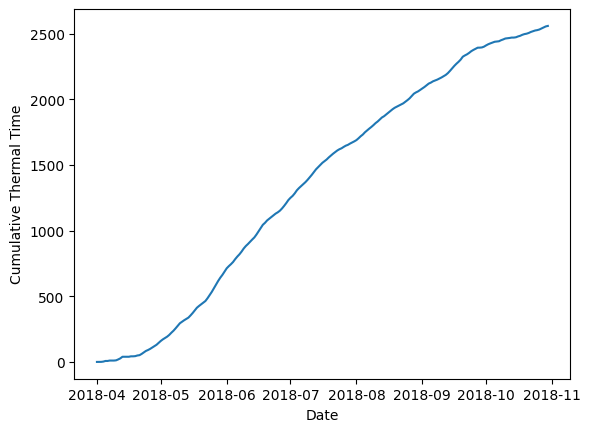

In [32]:
plt.plot(thermal_time.index, thermal_time)
plt.ylabel('Cumulative Thermal Time')
plt.xlabel('Date')
plt.show()

## Combining with other data sourc. 

Thermal time can also be used to compare growth conditions at the same development stage across fields or years better than day of year. 

We will now index Soil Water Content for the field of interest based on the thermal time rather than calander day to compare available water in the 2018, 2019 and 2020 seasons. 

First we will generate cumulative thermal time for all three seasons. 

In [82]:
# LST input data
input_data = SentinelHubStatistical.input_data(data_collection)

# Time of interest for each season
season_windows = [('2018-04-01', '2018-10-31'), ('2019-04-10', '2019-10-10'), ('2020-04-22', '2020-10-05')]

# crop specific base value over which growth occurs
base_value = 10

# Generate thermal time for each year
thermal_time_data = {}

for time_of_interest in season_windows:

    thermal_time = calculate_thermal_time(time_of_interest = time_of_interest, 
                                        input_data = input_data, 
                                        parcel_geo = foi, 
                                        config = config, 
                                        base_value=base_value)
    
    thermal_time_data[time_of_interest[0].split('-')[0]] = thermal_time
    


Now we will extract the soil water content for our field of interest in the same time interval. 

We will use the Soil Water Content available in the Planet Sandbox Data and use the Sentinel Hub Statsitcs API to generate a time series of SWC data. 

In [83]:
# Set SWC collection ID as input 
collection_id= "65f7e4fb-a27a-4fae-8d79-06a59d7e6ede"
data_collection = DataCollection.define_byoc(collection_id)


In [84]:
# source SWC data in time series

swc_time_series_evalscript = """
//VERSION=3
function setup() {
    return {
        input: [{bands: ["SWC", "dataMask"]}],
        output: [
            { id: "SWC", bands: 1, sampleType: "FLOAT32" },
            { id: "dataMask", bands: 1, sampleType: "UINT8" }
        ],
        mosaicking: "TILE"
    };
}

function evaluatePixel(samples) {
    var sample = samples[0].SWC
    var nodata = samples[0].dataMask

    return {
        SWC: [(sample) / 100],
        dataMask: [nodata]
    };
}
"""

### Request the data
We will source SWC data with the following parameters:

- From April 1st, 2018 to October 31st, 2020
- At the native resolution (0.01 degree -> ±1km)
- Using our previously defined function `(swc_time_series_evalscript)`
- Calculated for each day `(P1D)`
- Over the geometry our field of interest `(foi)`


In [85]:
input_data = SentinelHubStatistical.input_data(data_collection)

# Specifiy your time of interest (TOI) - we will set the whole time of interest to process all in single request
time_of_interest = '2018-04-01', '2020-10-05'

# Specify a resolution in degrees
resx = 0.01
resy = 0.01

# Use aggregation method to combine parameters
aggregation = SentinelHubStatistical.aggregation(
    evalscript=swc_time_series_evalscript, time_interval=time_of_interest, aggregation_interval="P1D", resolution=(resx, resy)
)

# Create the request
request = SentinelHubStatistical(
        aggregation=aggregation,
        input_data=[input_data],
        geometry=foi,
        config=config,
    )

In [86]:
# Post the requests
download_requests = [request.download_list[0]]
client = SentinelHubDownloadClient(config=config)
swc_stats_response = client.download(download_requests)

Format the time series 

In [87]:
series = pd.json_normalize(swc_stats_response[0]["data"])
series['date'] = pd.to_datetime(series['interval.from'])
series['date'] = series['date'].dt.date
series.set_index('date', inplace=True)
series = series[['outputs.SWC.bands.B0.stats.mean']].rename({'outputs.SWC.bands.B0.stats.mean':'SWC'}, axis= 1)
series['SWC'] = pd.to_numeric(series['SWC'], errors = 'coerce')
series = series['SWC'].interpolate() # Does this make sense here?


Plot the cumulative SWC against the cumulative thermal time to see how much water was available to the crops at the same point in development each season. For example here we can see SWC was higher in 2019 before becoming lower than the 2020 season later in the crops development. 

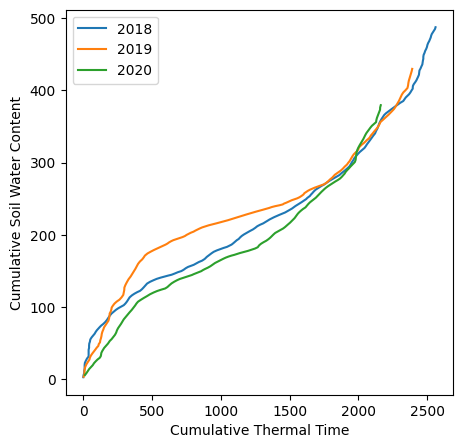

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for season, df in thermal_time_data.items():

    combined = pd.merge(df, series, left_index=True, right_index=True, how = 'left')
    ax.plot(combined.GDD, combined.SWC.cumsum(), label = f"{season}")

ax.set_ylabel('Cumulative Soil Water Content')
ax.set_xlabel('Cumulative Thermal Time')
plt.legend()
plt.show()



    